### source: https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/

In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

warnings.filterwarnings('ignore')
%matplotlib inline

## Loading in data

In [2]:
dataset = pd.read_csv('ratings.csv')

In [3]:
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
dataset.shape

(981756, 3)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [6]:
train.head()

,book_id,user_id,rating
341848,3423,4608,2
964349,9811,36373,5
645459,6485,2957,4
74960,750,42400,3
358670,3591,36886,5


In [7]:
test.head()

,book_id,user_id,rating
646451,6495,19643,5
614851,6175,8563,4
974393,9920,52110,3
21471,215,33864,5
272540,2728,16587,3


In [8]:
n_users = len(dataset.user_id.unique())
n_users

53424

In [9]:
n_books = len(dataset.book_id.unique())
n_books

10000

## Creating Neural Network
Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

In [10]:
# define embeddingg size (similar for both users and books)
dim_embedddings = 50
bias = 1

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books + 1, dim_embedddings, name="Book-Embedding")(book_input)
book_bias = Embedding(n_books + 1, bias, name="Book-Bias")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, dim_embedddings, name="User-Embedding")(user_input)
user_bias = Embedding(n_users + 1, bias, name="User-Bias")(user_input)

matrix_product = Multiply()([book_embedding, user_embedding])
matrix_product = Dropout(0.2)(matrix_product)

input_terms = Concatenate()([matrix_product, user_bias, book_bias])
input_terms = Flatten()(input_terms)

# add fully-connected-layers
dense_1 = Dense(50, activation="relu", name = "Dense1")(input_terms)
dense_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(20, activation="relu", name = "Dense2")(dense_1)
dense_2 = Dropout(0.2)(dense_2)
result = Dense(1, activation='relu', name='Activation')(dense_2)

# define model with 2 inputs and 1 output
model_mf = Model(inputs=[user_input, book_input], outputs=result)

# show model summary
model_mf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 50)        500050      Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        2671250     User-Input[0][0]                 
______________________________________________________________________________________________

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']
Train on 781476 samples, validate on 3928 samples
Epoch 1/5
781476/781476 [==============================] - 74s 94us/sample - loss: 1.2162 - mean_absolute_error: 0.8584 - val_loss: 0.7234 - val_mean_absolute_error: 0.6659
Epoch 2/5
781476/781476 [==============================] - 73s 93us/sample - loss: 0.7219 - mean_absolute_error: 0.6682 - val_loss: 0.7132 - val_mean_absolute_error: 0.6526
Epoch 3/5
781476/781476 [==============================] - 75s 96us/sample - loss: 0.4640 - mean_absolute_error: 0.5226 - val_loss: 0.7707 - val_mean_absolute_error: 0.6747
Epoch 4/5
781476/781476 [==============================] - 75s 96us/sample - loss: 0.3192 - mean_absolute_error: 0.4275 - val_loss: 0.8097 - val_mean_absolute_error: 0.6859
Epoch 5/5
781476/781476 [==============================] - 76s 98us/sample - loss: 0.2626 - mean_absolute_error: 0.3828 - val_loss: 0.8126 - val_mean_absolute_error: 0.6909


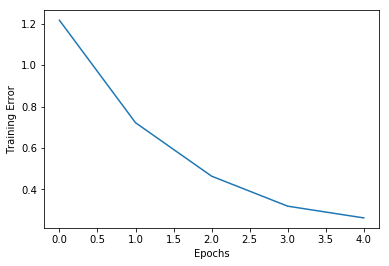

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

from tensorflow.keras.models import load_model
training = True

if not training and os.path.exists('regression_model_mf.h5'):
    model_mf = load_model('regression_model_mf.h5')
else:
    with tf.device('/device:CPU:0'):
        # specify learning rate (or use the default)
        opt_adam = Adam(lr = 0.002)

        # compile model
        model_mf.compile(optimizer = opt_adam, loss = ['mse'], metrics = ['mean_absolute_error'])

        # fit model
        history_mf = model_mf.fit([train.user_id, train.book_id],
                                  train.rating,
                                  batch_size = 256,
                                  validation_split = 0.005,
                                  epochs = 5,
                                  verbose = 1)
        model_mf.save('regression_model_mf.h5')
        plt.plot(history_mf.history['loss'])
        plt.xlabel("Epochs")
        plt.ylabel("Training Error")

In [12]:
with tf.device('/device:CPU:0'):
    print(model_mf.evaluate([test.user_id, test.book_id], test.rating))

196352/196352 [==============================] - 3s 17us/sample - loss: 0.8202 - mean_absolute_error: 0.6972
[0.8202156027514279, 0.69724303]


In [13]:
predictions = model_mf.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[4.8534503] 5
[3.8890433] 4
[3.4774358] 3
[3.6478062] 5
[3.2974663] 3
[4.1752725] 3
[3.2365608] 3
[4.4115815] 4
[4.28392] 3
[3.8061762] 5


[None, None, None, None, None, None, None, None, None, None]

## Visualizing Embeddings
Embeddings are weights that are learned to represent some specific variable like books and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [15]:
# Extract embeddings
book_em = model_mf.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [16]:
book_em_weights[:5]

array([[ 1.77818276e-02,  2.83188857e-02, -1.86010115e-02,
        -1.16406903e-02, -1.72842257e-02, -1.19963065e-02,
        -2.03814358e-03,  4.16733287e-02, -2.48421673e-02,
         4.59447242e-02, -1.81332231e-02,  5.40512800e-03,
         2.22119205e-02, -4.50099371e-02, -2.55554672e-02,
         2.33397223e-02,  2.82986499e-02, -3.25367823e-02,
         4.57887389e-02, -2.65136845e-02,  3.00967582e-02,
         6.90566376e-03,  4.78732474e-02, -3.90501991e-02,
        -1.65048018e-02,  8.81205872e-03, -1.94562078e-02,
         3.36494297e-03, -6.05892390e-04, -2.49305014e-02,
         9.14692879e-03,  2.85950787e-02, -2.87428033e-02,
        -2.55135540e-02, -1.92458518e-02,  1.27032511e-02,
        -3.22101936e-02,  4.29857895e-03,  2.08631903e-03,
         1.28787421e-02,  4.21237946e-03,  4.84009646e-02,
         3.26495208e-02,  2.70915963e-02, -3.17263231e-02,
         2.30730437e-02, -4.87314463e-02, -1.79160014e-02,
         4.03913297e-02,  8.35169107e-04],
       [-9.18

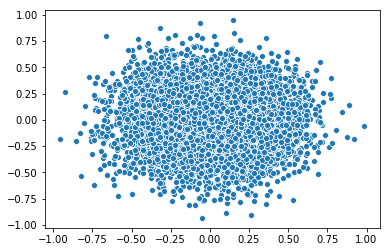

In [17]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [18]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0000001

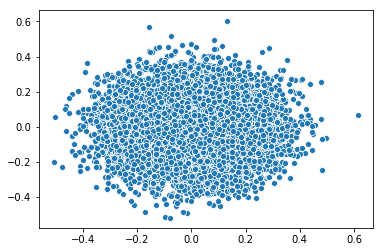

In [19]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.021s...
[t-SNE] Computed neighbors for 10001 samples in 7.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.275569
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.674980
[t-SNE] KL 

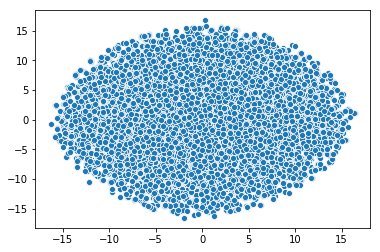

In [21]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making Recommendations

In [22]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [23]:
user = np.array([1 for i in range(len(book_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [25]:
predictions = model_mf.predict([user, book_data])

predictions = np.array([a[0] for a in predictions])

recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([9075, 4720, 7946, 7439, 3952])

In [26]:
# print predicted scores
predictions[recommended_book_ids]

array([4.8454957, 4.8158736, 4.7801833, 4.7585697, 4.7529526],
      dtype=float32)

In [27]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [28]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3951,3952,29430012,29430012,45743836,29,670026190,9.780670e+12,Amor Towles,2016.0,A Gentleman in Moscow,...,33394,46320,7226,517,1244,4654,14274,25631,https://images.gr-assets.com/books/1459524472m...,https://images.gr-assets.com/books/1459524472s...
4719,4720,319644,319644,7792859,49,439791464,9.780440e+12,Suzanne Collins,2006.0,Gregor and the Marks of Secret,...,23727,25671,1041,178,557,4117,9617,11202,https://images.gr-assets.com/books/1397854344m...,https://images.gr-assets.com/books/1397854344s...
7438,7439,820480,820480,2831944,46,1405092726,9.781405e+12,C.J. Sansom,2008.0,Revelation,...,11868,14266,752,48,209,1613,5696,6700,https://images.gr-assets.com/books/1327170369m...,https://images.gr-assets.com/books/1327170369s...
7945,7946,39926,39926,836516,43,60512180,9.780061e+12,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...,...,13037,14266,790,234,790,3493,5552,4197,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9074,9075,7199667,7199667,7867989,7,1599904780,9.781600e+12,Jessica Day George,2010.0,Princess of Glass,...,17052,17729,1669,145,694,3966,6525,6399,https://images.gr-assets.com/books/1397878579m...,https://images.gr-assets.com/books/1397878579s...
